<a href="https://colab.research.google.com/github/carspareidentifier/SparePartIdentifier/blob/main/CarSpareIdentifier(using_CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Get the dataset
!gdown --id 1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2
From (redirected): https://drive.google.com/uc?id=1oO2A6mmoOYRQsrVXvJUdCCvdiJMvPbK2&confirm=t&uuid=4171fe99-2182-4053-89b4-7309bef80a83
To: /content/car parts 50.zip
100% 150M/150M [00:02<00:00, 71.6MB/s]


In [ ]:
# Unzip the dataset
!unzip -q 'car parts 50.zip' -d dataset

In [ ]:
#define the training, validation, testing base directories
train_dir = 'dataset/car parts 50/train'
validation_dir = 'dataset/car parts 50/valid'
test_dir = 'dataset/car parts 50/test'

In [ ]:
#Define Target Size, Batch Size, and Class for Generators
TARGET_SIZE = (150,150)
BATCH_SIZE = 32
CLASS_MODE = 'sparse'

In [ ]:
def train_val_test_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the validation images
    TESTING_DIR (string): directory path containing the testing images
  Returns:
    train_generator, validation_generator, testing_generator: tuple containing the generators
  """
  # Instantiate the ImageDataGenerator class for the training dataset with augmentation
  train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range = 40,
      width_shift_range=.2,
      height_shift_range=.2,
      shear_range=.2,
      zoom_range=.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE
  )

  # Instantiate the ImageDataGenerator class for the validation dataset
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE
  )

  # Instantiate the ImageDataGenerator class for the testing dataset
  test_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(
      TESTING_DIR,
      target_size= TARGET_SIZE,
      batch_size = BATCH_SIZE,
      class_mode = CLASS_MODE,
      shuffle = False
  )

  return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator, test_generator = train_val_test_generators(train_dir, validation_dir, test_dir)

Found 8739 images belonging to 50 classes.
Found 250 images belonging to 50 classes.
Found 250 images belonging to 50 classes.


In [ ]:
#Define the model

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(50, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])

    return model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for unbalanced training data
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)
class_weights_dict = dict(zip(classes, class_weights))

In [ ]:
#Add callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [ ]:
# Save the model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    class_weight=class_weights_dict,
                    callbacks=[checkpoint, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - acc: 0.0346 - loss: 3.8777
Epoch 1: val_acc improved from -inf to 0.06400, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 63s 207ms/step - acc: 0.0347 - loss: 3.8774 - val_acc: 0.0640 - val_loss: 3.6182
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.1067 - loss: 3.4826
Epoch 2: val_acc improved from 0.06400 to 0.20800, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 188ms/step - acc: 0.1068 - loss: 3.4822 - val_acc: 0.2080 - val_loss: 2.9362
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - acc: 0.1747 - loss: 3.1421
Epoch 3: val_acc improved from 0.20800 to 0.30000, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 191ms/step - acc: 0.1748 - loss: 3.1419 - val_acc: 0.3000 - val_loss: 2.6927
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.2102 - loss: 2.9693
Epoch 4: val_acc improved from 0.30000 to 0.30400, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - acc: 0.2103 - loss: 2.9691 - val_acc: 0.3040 - val_loss: 2.5859
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.2584 - loss: 2.7158
Epoch 5: val_acc improved from 0.30400 to 0.37200, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 188ms/step - acc: 0.2584 - loss: 2.7157 - val_acc: 0.3720 - val_loss: 2.4560
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.2941 - loss: 2.5762
Epoch 6: val_acc improved from 0.37200 to 0.41200, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 188ms/step - acc: 0.2941 - loss: 2.5762 - val_acc: 0.4120 - val_loss: 2.1452
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - acc: 0.3161 - loss: 2.5147
Epoch 7: val_acc improved from 0.41200 to 0.42800, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 191ms/step - acc: 0.3161 - loss: 2.5146 - val_acc: 0.4280 - val_loss: 2.1729
Epoch 8/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - acc: 0.3336 - loss: 2.4323
Epoch 8: val_acc improved from 0.42800 to 0.46400, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - acc: 0.3336 - loss: 2.4323 - val_acc: 0.4640 - val_loss: 2.0551
Epoch 9/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - acc: 0.3597 - loss: 2.3174
Epoch 9: val_acc did not improve from 0.46400
274/274 ━━━━━━━━━━━━━━━━━━━━ 56s 204ms/step - acc: 0.3597 - loss: 2.3174 - val_acc: 0.4560 - val_loss: 2.0369
Epoch 10/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - acc: 0.3621 - loss: 2.2877
Epoch 10: val_acc did not improve from 0.46400
274/274 ━━━━━━━━━━━━━━━━━━━━ 59s 214ms/step - acc: 0.3622 - loss: 2.2876 - val_acc: 0.4280 - val_loss: 2.1231
Epoch 11/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - acc: 0.3912 - loss: 2.2273
Epoch 11: val_acc improved from 0.46400 to 0.50000, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 53s 193ms/step - acc: 0.3912 - loss: 2.2272 - val_acc: 0.5000 - val_loss: 1.8683
Epoch 12/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.3960 - loss: 2.1711
Epoch 12: val_acc improved from 0.50000 to 0.52800, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - acc: 0.3960 - loss: 2.1711 - val_acc: 0.5280 - val_loss: 1.8363
Epoch 13/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.4044 - loss: 2.0904
Epoch 13: val_acc did not improve from 0.52800
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - acc: 0.4044 - loss: 2.0905 - val_acc: 0.4720 - val_loss: 1.9224
Epoch 14/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.4181 - loss: 1.9998
Epoch 14: val_acc improved from 0.52800 to 0.55600, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - acc: 0.4181 - loss: 2.0000 - val_acc: 0.5560 - val_loss: 1.7546
Epoch 15/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - acc: 0.4289 - loss: 1.9802
Epoch 15: val_acc did not improve from 0.55600
274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 188ms/step - acc: 0.4289 - loss: 1.9802 - val_acc: 0.5280 - val_loss: 1.7091
Epoch 16/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - acc: 0.4589 - loss: 1.9410
Epoch 16: val_acc improved from 0.55600 to 0.58000, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - acc: 0.4589 - loss: 1.9411 - val_acc: 0.5800 - val_loss: 1.5968
Epoch 17/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.4539 - loss: 1.9201
Epoch 17: val_acc did not improve from 0.58000
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 185ms/step - acc: 0.4539 - loss: 1.9201 - val_acc: 0.5120 - val_loss: 1.7932
Epoch 18/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - acc: 0.4545 - loss: 1.9196
Epoch 18: val_acc did not improve from 0.58000
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - acc: 0.4545 - loss: 1.9195 - val_acc: 0.5160 - val_loss: 1.6381
Epoch 19/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.4704 - loss: 1.9006
Epoch 19: val_acc did not improve from 0.58000
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - acc: 0.4704 - loss: 1.9006 - val_acc: 0.5280 - val_loss: 1.8043
Epoch 20/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - acc: 0.4700 - loss: 1.8688
Epoch 20: val_acc did not improve from 0.58000
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s

274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 188ms/step - acc: 0.5094 - loss: 1.6976 - val_acc: 0.5960 - val_loss: 1.5722
Epoch 24/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.4890 - loss: 1.7658
Epoch 24: val_acc improved from 0.59600 to 0.61600, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 188ms/step - acc: 0.4890 - loss: 1.7658 - val_acc: 0.6160 - val_loss: 1.5147
Epoch 25/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5274 - loss: 1.6695
Epoch 25: val_acc did not improve from 0.61600
274/274 ━━━━━━━━━━━━━━━━━━━━ 81s 184ms/step - acc: 0.5274 - loss: 1.6697 - val_acc: 0.5600 - val_loss: 1.6334
Epoch 26/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.5025 - loss: 1.7499
Epoch 26: val_acc did not improve from 0.61600
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - acc: 0.5025 - loss: 1.7499 - val_acc: 0.5960 - val_loss: 1.5799
Epoch 27/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.5112 - loss: 1.7124
Epoch 27: val_acc improved from 0.61600 to 0.62000, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - acc: 0.5112 - loss: 1.7123 - val_acc: 0.6200 - val_loss: 1.5590
Epoch 28/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5276 - loss: 1.7008
Epoch 28: val_acc did not improve from 0.62000
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 184ms/step - acc: 0.5276 - loss: 1.7008 - val_acc: 0.5600 - val_loss: 1.6613
Epoch 29/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5198 - loss: 1.6431
Epoch 29: val_acc did not improve from 0.62000
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - acc: 0.5198 - loss: 1.6432 - val_acc: 0.6000 - val_loss: 1.5630
Epoch 30/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - acc: 0.5289 - loss: 1.6586
Epoch 30: val_acc did not improve from 0.62000
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - acc: 0.5289 - loss: 1.6586 - val_acc: 0.6120 - val_loss: 1.5407
Epoch 31/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5363 - loss: 1.6250
Epoch 31: val_acc did not improve from 0.62000
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s

274/274 ━━━━━━━━━━━━━━━━━━━━ 52s 188ms/step - acc: 0.5358 - loss: 1.6158 - val_acc: 0.6280 - val_loss: 1.4236
Epoch 35/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5461 - loss: 1.5610
Epoch 35: val_acc did not improve from 0.62800
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - acc: 0.5461 - loss: 1.5610 - val_acc: 0.5760 - val_loss: 1.6145
Epoch 36/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5539 - loss: 1.5460
Epoch 36: val_acc did not improve from 0.62800
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 184ms/step - acc: 0.5539 - loss: 1.5461 - val_acc: 0.5640 - val_loss: 1.5719
Epoch 37/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5488 - loss: 1.5413
Epoch 37: val_acc did not improve from 0.62800
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - acc: 0.5488 - loss: 1.5415 - val_acc: 0.6160 - val_loss: 1.5030
Epoch 38/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.5478 - loss: 1.5644
Epoch 38: val_acc did not improve from 0.62800
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s

274/274 ━━━━━━━━━━━━━━━━━━━━ 82s 187ms/step - acc: 0.5513 - loss: 1.5567 - val_acc: 0.6600 - val_loss: 1.4058
Epoch 40/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - acc: 0.5461 - loss: 1.5714
Epoch 40: val_acc improved from 0.66000 to 0.66400, saving model to best_model.h5


274/274 ━━━━━━━━━━━━━━━━━━━━ 82s 186ms/step - acc: 0.5462 - loss: 1.5713 - val_acc: 0.6640 - val_loss: 1.3374
Epoch 41/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.5572 - loss: 1.5248
Epoch 41: val_acc did not improve from 0.66400
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 187ms/step - acc: 0.5572 - loss: 1.5248 - val_acc: 0.6200 - val_loss: 1.5041
Epoch 42/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5681 - loss: 1.5137
Epoch 42: val_acc did not improve from 0.66400
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - acc: 0.5680 - loss: 1.5138 - val_acc: 0.6600 - val_loss: 1.4158
Epoch 43/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - acc: 0.5702 - loss: 1.4755
Epoch 43: val_acc did not improve from 0.66400
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 186ms/step - acc: 0.5702 - loss: 1.4756 - val_acc: 0.6280 - val_loss: 1.4765
Epoch 44/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5796 - loss: 1.4587
Epoch 44: val_acc did not improve from 0.66400
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s

274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 188ms/step - acc: 0.5664 - loss: 1.4780 - val_acc: 0.6840 - val_loss: 1.2949
Epoch 51/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.5850 - loss: 1.4549
Epoch 51: val_acc did not improve from 0.68400
274/274 ━━━━━━━━━━━━━━━━━━━━ 51s 185ms/step - acc: 0.5850 - loss: 1.4549 - val_acc: 0.6760 - val_loss: 1.4811
Epoch 52/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.5893 - loss: 1.4245
Epoch 52: val_acc did not improve from 0.68400
274/274 ━━━━━━━━━━━━━━━━━━━━ 50s 184ms/step - acc: 0.5893 - loss: 1.4246 - val_acc: 0.6400 - val_loss: 1.4361
Epoch 53/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - acc: 0.5921 - loss: 1.4378
Epoch 53: val_acc did not improve from 0.68400
274/274 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - acc: 0.5921 - loss: 1.4378 - val_acc: 0.6320 - val_loss: 1.5508
Epoch 54/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - acc: 0.5771 - loss: 1.4593
Epoch 54: val_acc did not improve from 0.68400
274/274 ━━━━━━━━━━━━━━━━━━━━ 52s

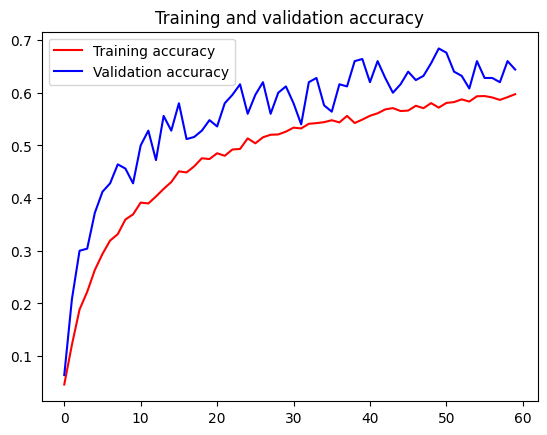

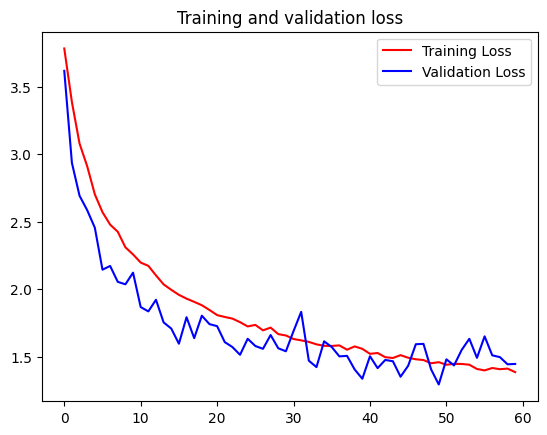

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy chart
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Loss chart
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the Model
import math

test_steps = math.ceil(test_generator.n / test_generator.batch_size)

results = model.evaluate(test_generator, steps=test_steps)
print('test loss, test acc:', results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.7148 - loss: 1.0972
test loss, test acc: [1.2259246110916138, 0.6800000071525574]


In [ ]:
# Create a prediction from model
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Define true_classes and class_labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Make sure that predicted_classes and true_classes have the same length
if len(predicted_classes) > len(true_classes):
    predicted_classes = predicted_classes[:len(true_classes)]  # Trim predictions to match true_classes length

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


In [ ]:
# Use scikit-learn to generate a detailed classification report
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

                      precision    recall  f1-score   support

      AIR COMPRESSOR       0.67      0.80      0.73         5
          ALTERNATOR       0.83      1.00      0.91         5
             BATTERY       0.57      0.80      0.67         5
       BRAKE CALIPER       0.67      0.80      0.73         5
           BRAKE PAD       0.45      1.00      0.62         5
         BRAKE ROTOR       0.50      0.60      0.55         5
            CAMSHAFT       0.75      0.60      0.67         5
          CARBERATOR       0.57      0.80      0.67         5
        CLUTCH PLATE       0.57      0.80      0.67         5
         COIL SPRING       1.00      1.00      1.00         5
          CRANKSHAFT       0.75      0.60      0.67         5
       CYLINDER HEAD       0.50      0.60      0.55         5
         DISTRIBUTOR       1.00      0.20      0.33         5
        ENGINE BLOCK       0.67      0.80      0.73         5
        ENGINE VALVE       0.83      1.00      0.91         5
       

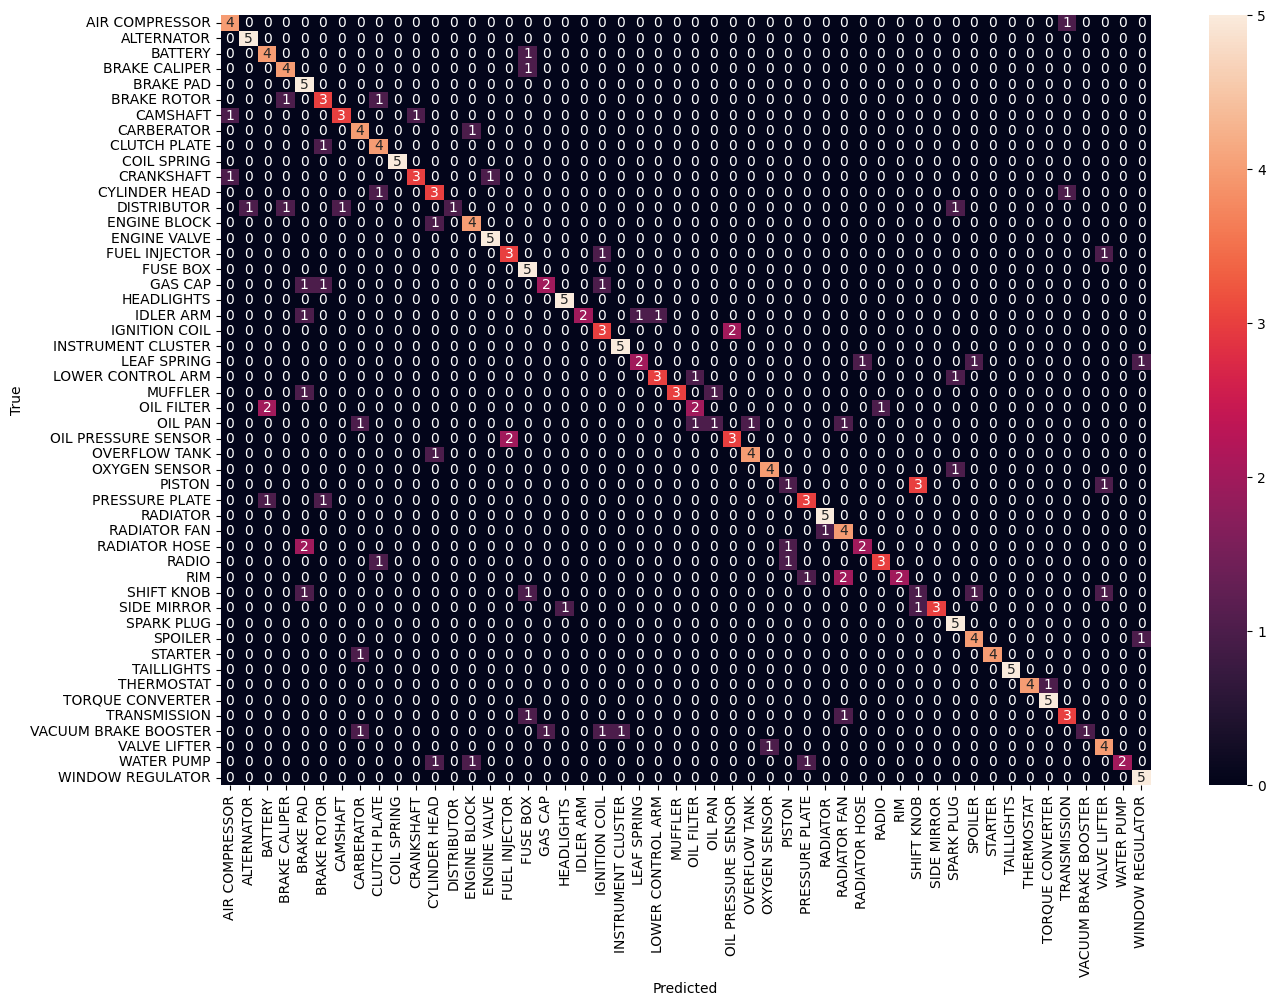

In [ ]:
# Add Confusion matrix to visualize the performance across the different classes
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#Testing the model prediction
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array

# Function to preprocess the image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array

# Load the model
model = load_model('best_model.h5')

# Load class labels using the train_generator's class_indices
class_labels = {v: k for k, v in train_generator.class_indices.items()}

Saving Radiator.jpeg to Radiator (1).jpeg
1/1 [==============================] - 0s 19ms/step
Filename: Radiator (1).jpeg
Predicted class: RADIATOR
Confidence: 69.77%


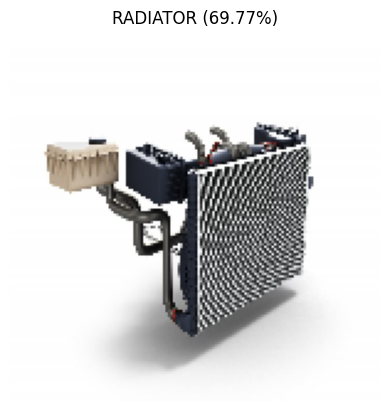

In [ ]:
# Upload files and predict
uploaded = files.upload()

for fn in uploaded.keys():
    # Preprocess the image
    img, img_array = preprocess_image(fn)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Output results
    print(f"Filename: {fn}")
    print(f"Predicted class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}%")

    # Display the image
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.show()

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import io  # Import io module
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


# ... (your existing code for model loading and class labels)...
#Load the model
model = load_model('best_model.h5')

#Load class labels using the train_generator's class_indices
class_labels = {v: k for k, v in train_generator.class_indices.items()}


def preprocess_image(image):  # Modified preprocess_image for Gradio
    """Preprocesses the image for prediction."""
    # Convert PIL Image to BytesIO
    image_bytes = io.BytesIO()
    image.save(image_bytes, format='PNG')  # Or appropriate format
    image_bytes.seek(0)  # Reset file pointer

    # Now you can use load_img with the BytesIO object
    img = load_img(image_bytes, target_size=(150, 150))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array


def predict_image_gradio(image):
    """Predicts the class of a car part in the given image (Gradio version)."""
    # Preprocess the image
    img, img_array = preprocess_image(image)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Create result image with prediction (optional)
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.savefig("result.png")  # Save result to a file (optional)
    plt.close()

    # Return results
    return "result.png", f"Predicted class: {predicted_class_label}\nConfidence: {confidence:.2f}%"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_image_gradio,
    inputs=gr.Image(type="pil"),  # Input is an image
    outputs=[gr.Image(label="Result"), gr.Textbox(label="Prediction")],
    title="Mechanic Shop Car Part Identifier",
    description="Upload an image of a car part to identify it.",
    theme="default",  # You can try different themes
)

iface.launch(debug=False)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://21311d3d82d767dd0c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import io  # Import io module
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model


# ... (your existing code for model loading and class labels)...
#Load the model
model = load_model('best_model.h5')

#Load class labels using the train_generator's class_indices
class_labels = {v: k for k, v in train_generator.class_indices.items()}


def preprocess_image(image):  # Modified preprocess_image for Gradio
    """Preprocesses the image for prediction."""
    # Convert PIL Image to BytesIO
    image_bytes = io.BytesIO()
    image.save(image_bytes, format='PNG')  # Or appropriate format
    image_bytes.seek(0)  # Reset file pointer

    # Now you can use load_img with the BytesIO object
    img = load_img(image_bytes, target_size=(150, 150))

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img, img_array


def predict_image_gradio(image):
    """Predicts the class of a car part in the given image (Gradio version)."""
    # Preprocess the image
    img, img_array = preprocess_image(image)

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(prediction) * 100

    # Create result image with prediction (optional)
    plt.imshow(img)
    plt.title(f"{predicted_class_label} ({confidence:.2f}%)")
    plt.axis('off')  # Hide the axis
    plt.savefig("result.png")  # Save result to a file (optional)
    plt.close()

    # Return results
    return "result.png", f"Predicted class: {predicted_class_label}\nConfidence: {confidence:.2f}%"

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_image_gradio,
    inputs=gr.Image(type="pil"),  # Input is an image
    outputs=[gr.Image(label="Result"), gr.Textbox(label="Prediction")],
    title="Mechanic Shop Car Part Identifier",
    description="Upload an image of a car part to identify it.",
    theme="default",  # You can try different themes
)

iface.launch(debug=True)